## <font color='lightblue'> <h1><b>Desafio  Final:</b> "Análisis de la Demanda de Energía Eléctrica en Londres"</h1> </font>
## </h3> (A partir del datos suministrados por SmartMeters) </h3>
<h3><blockquote>
        <ul>
          <li>Análisis de demanda y patrones de consumo </li>
          <li>Identificación de features representativas del comportamiento de la demanda </li>
          <li>Análisis de la demanda como serie de tiempo en modelos predictivos </li>
        </ul>
</blockquote>

<img src=https://www.wannapik.com/media/W1siZiIsIjIwMTYvMDgvMjIvOW95M3V4MGdybF81dm5nNjJ6bmNrX2VudmkwMDI0LnBuZyJdXQ/60d70353518b92e1/5vng62znck_envi0024.png>

 <font color='lightgreen'> <h2><b>Grupo 5</b></h2> </font>
<blockquote>
        <ul>
          <li>Panizza, Camila</li>
          <li>Ron, Juan Ignacio</li>
          <li>Sirai, Juan Bautista</li>
        </ul>
</blockquote>

# <font color='skyblue'> Carga de Librerias</font>

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, confusion_matrix, classification_report, accuracy_score
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist,squareform

from sklearn.pipeline import Pipeline, make_pipeline, make_union, FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import sys
import glob
import plotly.express as px
import os

from scipy import stats
from statistics import mode

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA

##########
import warnings
warnings.filterwarnings('ignore')

<a id="section_carga_datasets"></a> 

# <font color='skyblue'> Carga de DataSets</font>

[Volver](#section_toc)

####  El primer dataset que cargaremos, es sobre mediciones diarias de consumo de energía eléctrica en la ciudad de Londres, desde el 2011 hasta el 2014. El mismo se encuentra individualizado por medidor.

In [3]:
# Dataset de Mediciones Diarias por manzana y medidor
energy = pd.read_csv('data/daily_dataset.csv/daily_dataset.csv')
energy.dropna(subset=['energy_sum'], axis=0, inplace=True)

In [4]:
# Dataset de información por cada medidor
info_df = pd.read_csv('data/informations_households.csv')

In [5]:
# Dataset de climas

weather= pd.read_csv('data/weather_daily_darksky.csv')

In [6]:
# Dataset de feriados bancarios

holidays= pd.read_csv('data/uk_bank_holidays.csv')

<a id="section_data_wrangling"></a> 
# <font color='lightblue'> Data Wrangling </font>
[Volver](#section_toc)

#### Transformaciones sobre DF Weather

In [7]:
#Convertimos variables a formato DateTime

weather['day']=  pd.to_datetime(weather['time'])

In [8]:
# Me quedo con las variables más interesantes y completo los NA con Bfill (tener en cuenta que era 1 registro faltante en enero de 2014, de nubosidad)

weather.fillna(axis=0, method='bfill', inplace=True )
weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase','day']]
weather["temperatureMean"]=(weather["temperatureMax"]+weather["temperatureMin"])/2
weather["apparent_temperatureMean"]=(weather["apparentTemperatureMax"]+weather["apparentTemperatureMin"])/2

In [9]:
weather.sample(5)

,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,day,temperatureMean,apparent_temperatureMean
418,6.89,342,3.31,0.65,5.17,1012.91,3.34,13.20,0.83,-1.39,3.34,1.0,2.23,3.45,6.89,-0.33,0.50,2012-11-28 00:00:00,5.170,1.505
152,11.41,229,6.17,0.43,4.56,1016.78,11.41,12.89,0.80,2.59,11.41,4.0,5.92,6.94,11.41,4.06,0.80,2012-05-13 23:00:00,9.175,7.735
441,16.51,257,10.42,0.70,6.28,1009.25,16.51,12.38,0.76,10.62,16.51,5.0,10.62,12.62,16.51,12.62,0.51,2013-06-22 23:00:00,14.565,14.565
296,4.08,94,1.11,0.79,0.56,1033.06,4.08,3.28,0.92,-1.81,4.08,1.0,1.06,1.39,4.08,0.15,0.45,2012-02-06 00:00:00,2.735,2.115
855,7.66,157,2.76,0.37,2.19,1010.13,6.26,6.36,0.89,2.42,6.26,1.0,5.76,1.97,7.66,1.97,0.66,2014-01-21 00:00:00,4.815,4.115


#### Transformaciones sobre df Energy

In [10]:
# Asimismo, desagregamos la información relativa a las fechas y ordenamos

energy['day'] = pd.to_datetime(energy['day'])
energy['year'] = energy['day'].dt.year
energy['month'] = energy['day'].dt.month
energy['dayofweek'] = energy['day'].dt.dayofweek
energy['day_name'] = energy['day'].dt.day_name()
energy = energy.sort_values(by='day')

In [11]:
energy.sample(5)

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,year,month,dayofweek,day_name
7146,MAC004548,2012-01-29,0.1660,0.387292,1.518,48,0.416509,18.590,0.034,2012,1,6,Sunday
3338290,MAC002499,2012-12-09,0.2725,0.300833,0.705,48,0.106978,14.440,0.172,2012,12,6,Sunday
3404250,MAC002664,2012-12-07,0.0785,0.108583,0.385,48,0.078480,5.212,0.034,2012,12,4,Friday
1094060,MAC005170,2014-01-21,0.1600,0.156125,0.265,48,0.059995,7.494,0.051,2014,1,1,Tuesday
1983330,MAC001874,2012-12-26,0.4655,0.482229,0.779,48,0.096241,23.147,0.329,2012,12,2,Wednesday


#### Transformaciones sobre INFO clientes

In [12]:
# En el df de datos del cliente, cambiamos el nombre a la columna 'file' por 'block', por ser potencialmente útil para los modelos

info_df = info_df.rename(columns = {'file' : 'block'})
info_df.sample(5)

,LCLid,stdorToU,Acorn,Acorn_grouped,block
4576,MAC002418,ToU,ACORN-P,Adversity,block_91
2136,MAC001624,Std,ACORN-E,Affluent,block_42
4545,MAC002387,Std,ACORN-O,Adversity,block_90
2157,MAC005011,ToU,ACORN-E,Affluent,block_43
2700,MAC000044,ToU,ACORN-F,Comfortable,block_54


In [13]:
# Vemos que hay solo dos Medidores con Acorn-. Suponemos que es un error de tipeo. Por no tener mayor certeza a cual corresponde, los excluiremos del análisis
info_df.loc[info_df['Acorn']=='ACORN-',"LCLid"].value_counts()

MAC001074    1
MAC005492    1
Name: LCLid, dtype: int64

In [14]:
#Nos quedamos con los registros que no pertenecen a Acorn-
info_df = info_df.loc[(info_df['LCLid']!='MAC005492') & (info_df['LCLid']!='MAC001074')]
info_df.Acorn.value_counts()

ACORN-E    1567
ACORN-Q     831
ACORN-F     684
ACORN-H     455
ACORN-L     342
ACORN-D     292
ACORN-G     205
ACORN-K     165
ACORN-A     157
ACORN-N     152
ACORN-C     151
ACORN-M     113
ACORN-J     112
ACORN-P     110
ACORN-O     103
ACORN-I      51
ACORN-U      49
ACORN-B      25
Name: Acorn, dtype: int64

In [15]:
# Modificamos la columna 'Acorn_grouped' para que coincida con la escala real (la que viene fue creada por quien compiló los dfs)

affluent_mask = (info_df['Acorn'] == 'ACORN-A') | (info_df['Acorn_grouped'] == 'ACORN-B') | (info_df['Acorn_grouped'] == 'ACORN-C')
rising_mask = (info_df['Acorn'] == 'ACORN-D') | (info_df['Acorn_grouped'] == 'ACORN-E')
confortable_mask = (info_df['Acorn'] == 'ACORN-F') | (info_df['Acorn_grouped'] == 'ACORN-G') | (info_df['Acorn_grouped'] == 'ACORN-H') | (info_df['Acorn_grouped'] == 'ACORN-I') | (info_df['Acorn_grouped'] == 'ACORN-J')
streched_mask = (info_df['Acorn'] == 'ACORN-K') | (info_df['Acorn_grouped'] == 'ACORN-L') | (info_df['Acorn_grouped'] == 'ACORN-M') | (info_df['Acorn_grouped'] == 'ACORN-N')
adversity_mask = (info_df['Acorn'] == 'ACORN-O') | (info_df['Acorn_grouped'] == 'ACORN-P') | (info_df['Acorn_grouped'] == 'ACORN-Q')
household_mask = (info_df['Acorn'] == 'ACORN-U')

In [16]:
info_df.loc[affluent_mask,'Acorn_grouped'] = 'Affluent'
info_df.loc[rising_mask,'Acorn_grouped'] = 'Rising'
info_df.loc[confortable_mask,'Acorn_grouped'] = 'Comfortable'
info_df.loc[streched_mask,'Acorn_grouped'] = 'Stretched'
info_df.loc[adversity_mask,'Acorn_grouped'] = 'Adversity'
info_df.loc[household_mask ,'Acorn_grouped'] = 'NP_Household'

#### Transformaciones sobre Holidays Dataset

In [17]:
# Pasamos la columna 'Bank holidays' a formato fecha y la seteamos como índice

holidays['date']=  pd.to_datetime(holidays['Bank holidays'])
holidays = holidays.set_index(holidays['date'], drop = True)

###  <font color='lightblue'> ``Comenzamos a realizar las uniones entre nuestros DataSets`` </font>

In [18]:
# Merge con DF Medidores

df_energy = energy.merge(info_df, how='left',left_on="LCLid",right_on="LCLid")

print('Corroboramos no haber perdido registros durante el shape')
display(energy.shape,df_energy.shape)
print(df_energy.isnull().sum()/df_energy.shape[0])

Corroboramos no haber perdido registros durante el shape


(3510403, 13)

(3510403, 17)

LCLid            0.000000
day              0.000000
energy_median    0.000000
energy_mean      0.000000
energy_max       0.000000
energy_count     0.000000
energy_std       0.003219
energy_sum       0.000000
energy_min       0.000000
year             0.000000
month            0.000000
dayofweek        0.000000
day_name         0.000000
stdorToU         0.000222
Acorn            0.000222
Acorn_grouped    0.000222
block            0.000222
dtype: float64


In [19]:
df_energy.sample(5)

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,year,month,dayofweek,day_name,stdorToU,Acorn,Acorn_grouped,block
2203130,MAC002543,2013-06-21,0.041,0.040708,0.043,48,0.000743,1.954,0.039,2013,6,4,Friday,Std,ACORN-E,Affluent,block_12
2180843,MAC002329,2013-06-17,0.010,0.032937,0.185,48,0.044550,1.581,0.000,2013,6,0,Monday,Std,ACORN-F,Comfortable,block_53
255246,MAC000049,2012-06-11,0.519,0.848979,3.366,48,0.765946,40.751,0.166,2012,6,0,Monday,Std,ACORN-E,Affluent,block_35
257562,MAC002435,2012-06-12,0.049,0.067229,0.416,48,0.075489,3.227,0.013,2012,6,1,Tuesday,Std,ACORN-P,Adversity,block_93
1080160,MAC000810,2012-11-27,0.145,0.158562,0.491,48,0.073237,7.611,0.100,2012,11,1,Tuesday,ToU,ACORN-Q,Adversity,block_105


In [20]:
# En el df de clima, la columna 'day' tiene registros con valor de hora que al truncar genera duplicados. Redondeamos al día más cercano.

weather['day'] = weather['day'].apply(lambda x: x.round('1d'))

In [21]:
# Merge FINAL

df_energy_join = df_energy.set_index('day')
weather_join = weather.set_index('day')
df_final =  df_energy_join.join(weather_join, on='day', how = 'left').reset_index()
#df_final =  df_energy.merge(weather, on='day')
print('Corroboramos no haber perdido registros durante el shape')
display(energy.shape, df_final.shape)
print(df_final.isnull().sum()/df_final.shape[0])

Corroboramos no haber perdido registros durante el shape


(3510403, 13)

(3510403, 36)

day                         0.000000
LCLid                       0.000000
energy_median               0.000000
energy_mean                 0.000000
energy_max                  0.000000
energy_count                0.000000
energy_std                  0.003219
energy_sum                  0.000000
energy_min                  0.000000
year                        0.000000
month                       0.000000
dayofweek                   0.000000
day_name                    0.000000
stdorToU                    0.000222
Acorn                       0.000222
Acorn_grouped               0.000222
block                       0.000222
temperatureMax              0.000000
windBearing                 0.000000
dewPoint                    0.000000
cloudCover                  0.000000
windSpeed                   0.000000
pressure                    0.000000
apparentTemperatureHigh     0.000000
visibility                  0.000000
humidity                    0.000000
apparentTemperatureLow      0.000000
a

___________________________________________________________________________
<a id="section_modelado"></a> 
# <font color='lightblue'> Clustering </font>
[Volver](#section_toc)

In [22]:
df_final.head(5)

,day,LCLid,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,year,...,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,temperatureMean,apparent_temperatureMean
0,2011-11-23,MAC000155,0.3020,0.421864,0.961,22,0.240825,9.281,0.110,2011,...,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94,7.085,6.27
1,2011-11-23,MAC000147,0.0750,0.108429,0.315,28,0.071653,3.036,0.033,2011,...,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94,7.085,6.27
2,2011-11-23,MAC000148,0.0480,0.045821,0.049,28,0.008170,1.283,0.008,2011,...,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94,7.085,6.27
3,2011-11-23,MAC000153,0.6765,0.904250,2.407,24,0.592275,21.702,0.261,2011,...,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94,7.085,6.27
4,2011-11-23,MAC000156,0.2745,0.296500,0.512,22,0.108046,6.523,0.162,2011,...,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94,7.085,6.27


In [23]:
nonzero_mask = df_final['energy_mean'] != 0.000000
df_final_filtered = df_final[nonzero_mask]

In [24]:
df_final_clustering = df_final_filtered.drop(columns = ['energy_count', 'year', 'dayofweek', 'day_name',
                                         'temperatureMax', 'windBearing', 'dewPoint', 'cloudCover',
                                         'windSpeed', 'pressure', 'apparentTemperatureHigh', 'visibility',
                                         'humidity', 'apparentTemperatureLow', 'apparentTemperatureMax',
                                         'uvIndex', 'temperatureLow', 'temperatureMin', 'temperatureHigh',
                                         'apparentTemperatureMin', 'moonPhase', 'temperatureMean',
                                         'apparent_temperatureMean'])

In [25]:
df_final_clustering.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3495265 entries, 0 to 3510402
Data columns (total 13 columns):
 #   Column         Dtype         
---  ------         -----         
 0   day            datetime64[ns]
 1   LCLid          object        
 2   energy_median  float64       
 3   energy_mean    float64       
 4   energy_max     float64       
 5   energy_std     float64       
 6   energy_sum     float64       
 7   energy_min     float64       
 8   month          int64         
 9   stdorToU       object        
 10  Acorn          object        
 11  Acorn_grouped  object        
 12  block          object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(5)
memory usage: 373.3+ MB


In [26]:
### Hacemos un group by para mostrar en una tabla la complejidad del total del dataset
file_list = df_final_clustering.groupby(['block', 'Acorn'])['LCLid','day'].agg(\
                                    {'LCLid' : 'nunique', 'day' : 'count'})
file_list = file_list.rename(columns = {'day' : 'measures'})
#file_list

## Clustering por 'Acorn'

### Clustering K-Means

In [27]:
df_acorn_clustering = df_final_clustering.groupby(['Acorn'])['energy_std', 'energy_mean'].agg(\
                                    {'energy_std' : 'mean', 'energy_mean' : 'mean'})

In [28]:
df_acorn_clustering.head()

,energy_std,energy_mean
Acorn,,
ACORN-A,0.262627,0.398735
ACORN-B,0.186137,0.248845
ACORN-C,0.198575,0.249801
ACORN-D,0.214019,0.284808
ACORN-E,0.182968,0.217671


In [29]:
df_acorn_clustering.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, ACORN-A to ACORN-U
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   energy_std   18 non-null     float64
 1   energy_mean  18 non-null     float64
dtypes: float64(2)
memory usage: 432.0+ bytes


In [30]:
scaler = StandardScaler()
X_acorn_scaled = scaler.fit_transform(df_acorn_clustering)

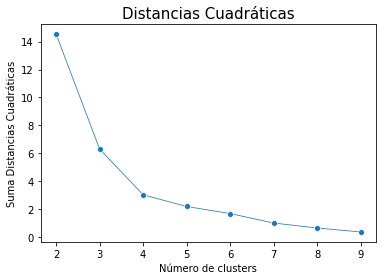

In [31]:
sq_distances=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(X_acorn_scaled)
    sq_distances.append(kmeans.inertia_)

sns.lineplot(x=k_values,y=sq_distances,marker='o',size=30,legend=False);
plt.ylabel('Suma Distancias Cuadráticas');plt.xlabel('Número de clusters');
plt.title('Distancias Cuadráticas', fontsize = 15);
plt.savefig('acorn clustering - kmeans - distancias.png')

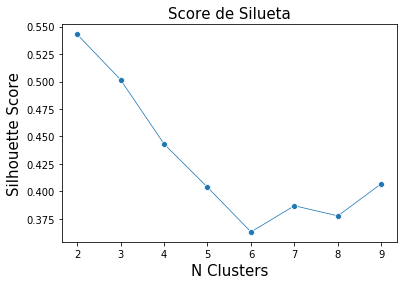

In [32]:
from sklearn.metrics import silhouette_score, silhouette_samples

sil = []
k_values = range (2,10)

for k in k_values:
    kmeans = KMeans(n_clusters = k, n_init = 10, random_state = 12)
    kmeans.fit(X_acorn_scaled)
    score = silhouette_score(X_acorn_scaled, kmeans.labels_)
    sil.append(score)
    
sns.lineplot(x = k_values, y = sil, marker = 'o', size = 30, legend = False);
plt.ylabel('Silhouette Score', fontsize = 15);plt.xlabel('N Clusters', fontsize = 15);
plt.title('Score de Silueta', fontsize = 15);
plt.savefig('acorn clustering - kmeans - silhouette.png')

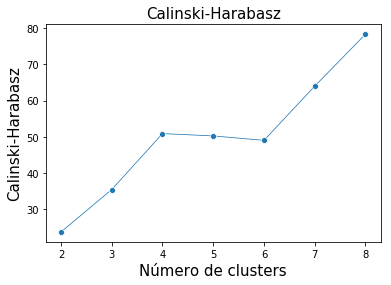

In [33]:
k_values=range(2,9);
ch_scores=[]

for k in k_values:
    
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(X_acorn_scaled)
    score=calinski_harabasz_score(X_acorn_scaled,kmeans.labels_)
    ch_scores.append(score)

sns.lineplot(x=k_values,y=ch_scores,marker='o',size=30,legend=False);
plt.ylabel('Calinski-Harabasz',fontsize=15);plt.xlabel('Número de clusters', fontsize=15);
plt.title('Calinski-Harabasz', fontsize = 15);
plt.savefig('acorn clustering - kmeans - c-h.png')

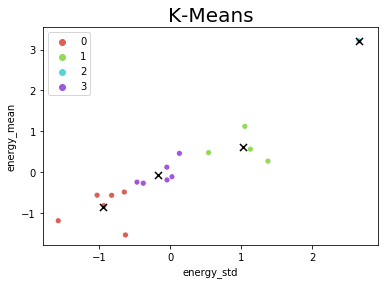

In [34]:
kmeans = KMeans(n_clusters = 4, n_init = 10, random_state = 0)
kmeans.fit(X_acorn_scaled)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_

sns.scatterplot(x=X_acorn_scaled[:,0],y=X_acorn_scaled[:,1],hue=labels,legend='full',palette=sns.color_palette("hls", 4));
plt.xlabel('energy_std', fontsize=10);plt.ylabel('energy_mean', fontsize=10);
plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=50,color='k');
plt.title('K-Means', fontsize=20);
plt.savefig('acorn clustering - kmeans - resultados.png')

### Clustering Jerárquico

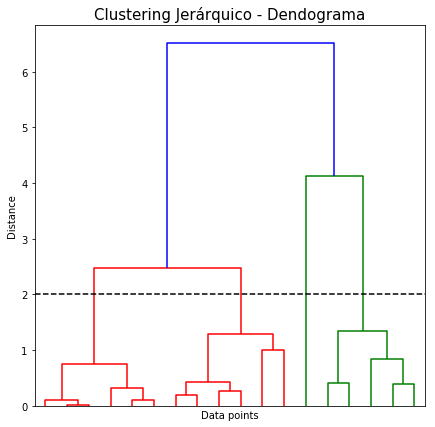

In [35]:
Z = linkage(X_acorn_scaled, 'ward');

plt.figure(figsize=[7,7])
plt.title('Clustering Jerárquico - Dendograma', fontsize = 15)
plt.xlabel('Data points')
plt.ylabel('Distance')

color_palette=['r','g','y','m'];

hierarchy.set_link_color_palette(color_palette) 

dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=5.,  
    color_threshold=6,     
)
plt.hlines(2,0,2000,linestyle='--')
plt.xticks([])
plt.savefig('acorn clustering - jerarquico - dendograma.png')
plt.show()

In [36]:
c, dists = cophenet(Z, pdist(X_acorn_scaled))
print('Coeficiente cofenético: ', c)

Coeficiente cofenético:  0.6208396129942453


Cluster labels:
 [4 3 3 3 1 2 1 1 2 3 1 1 1 2 2 2 2 3]


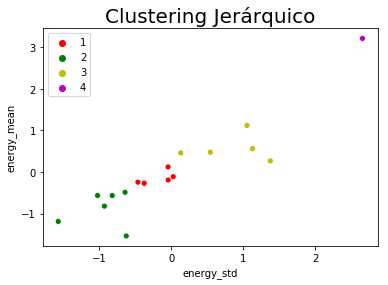

In [37]:
labels = fcluster(Z,4,criterion='maxclust');

print('Cluster labels:\n',labels)

sns.scatterplot(x = X_acorn_scaled[:,0] , y = X_acorn_scaled[:,1], hue = labels, legend = 'full', palette = color_palette);
plt.xlabel('energy_std', fontsize = 10);plt.ylabel('energy_mean',fontsize = 10);
plt.title('Clustering Jerárquico', fontsize = 20);
plt.savefig('acorn clustering - jerarquico - resultados.png')

In [38]:
df_acorn_clustering = df_acorn_clustering.reset_index()
df_acorn_clustering['cluster'] = labels

In [39]:
affluent_mask = (df_acorn_clustering['Acorn'] == 'ACORN-A') | (df_acorn_clustering['Acorn'] == 'ACORN-B') | (df_acorn_clustering['Acorn'] == 'ACORN-C')
rising_mask = (df_acorn_clustering['Acorn'] == 'ACORN-D') | (df_acorn_clustering['Acorn'] == 'ACORN-E')
confortable_mask = (df_acorn_clustering['Acorn'] == 'ACORN-F') | (df_acorn_clustering['Acorn'] == 'ACORN-G') | (df_acorn_clustering['Acorn'] == 'ACORN-H') | (df_acorn_clustering['Acorn'] == 'ACORN-I') | (df_acorn_clustering['Acorn'] == 'ACORN-J')
streched_mask = (df_acorn_clustering['Acorn'] == 'ACORN-K') | (df_acorn_clustering['Acorn'] == 'ACORN-L') | (df_acorn_clustering['Acorn'] == 'ACORN-M') | (df_acorn_clustering['Acorn'] == 'ACORN-N')
adversity_mask = (df_acorn_clustering['Acorn'] == 'ACORN-O') | (df_acorn_clustering['Acorn'] == 'ACORN-P') | (df_acorn_clustering['Acorn'] == 'ACORN-Q')
household_mask = (df_acorn_clustering['Acorn'] == 'ACORN-U')

In [40]:
df_acorn_clustering.loc[affluent_mask,'Acorn_grouped'] = 'Affluent'
df_acorn_clustering.loc[rising_mask,'Acorn_grouped'] = 'Rising'
df_acorn_clustering.loc[confortable_mask,'Acorn_grouped'] = 'Comfortable'
df_acorn_clustering.loc[streched_mask,'Acorn_grouped'] = 'Stretched'
df_acorn_clustering.loc[adversity_mask,'Acorn_grouped'] = 'Adversity'
df_acorn_clustering.loc[household_mask ,'Acorn_grouped'] = 'NP_Household'

In [41]:
df_acorn_clustering.sort_values(by = 'cluster', ascending = True)

,Acorn,energy_std,energy_mean,cluster,Acorn_grouped
4,ACORN-E,0.182968,0.217671,1,Rising
6,ACORN-G,0.180855,0.213401,1,Comfortable
7,ACORN-H,0.180787,0.230448,1,Comfortable
12,ACORN-M,0.170734,0.209023,1,Stretched
10,ACORN-K,0.168083,0.210506,1,Stretched
11,ACORN-L,0.170871,0.209796,1,Stretched
8,ACORN-I,0.162683,0.197343,2,Comfortable
15,ACORN-P,0.163179,0.140144,2,Adversity
14,ACORN-O,0.153973,0.179153,2,Adversity
13,ACORN-N,0.157285,0.192991,2,Stretched


## Clustering por 'block'

### Clustering K-Means

In [42]:
df_block_clustering = df_final_clustering.groupby(['block'])['energy_std', 'energy_mean'].agg(\
                                    {'energy_std' : 'mean', 'energy_mean' : 'mean'})

In [43]:
df_block_clustering.head()

,energy_std,energy_mean
block,,
block_0,0.285281,0.456619
block_1,0.263829,0.391660
block_10,0.214464,0.289769
block_100,0.145905,0.158537
block_101,0.148362,0.173383


In [44]:
df_block_clustering.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112 entries, block_0 to block_99
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   energy_std   112 non-null    float64
 1   energy_mean  112 non-null    float64
dtypes: float64(2)
memory usage: 2.6+ KB


In [45]:
scaler = StandardScaler()
X_block_scaled = scaler.fit_transform(df_block_clustering)

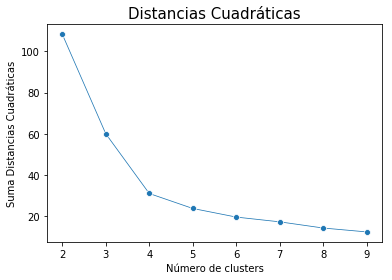

In [46]:
sq_distances=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(X_block_scaled)
    sq_distances.append(kmeans.inertia_)

sns.lineplot(x=k_values,y=sq_distances,marker='o',size=30,legend=False);
plt.ylabel('Suma Distancias Cuadráticas');plt.xlabel('Número de clusters');
plt.title('Distancias Cuadráticas', fontsize = 15);
plt.savefig('block clustering - kmeans - distancias.png')

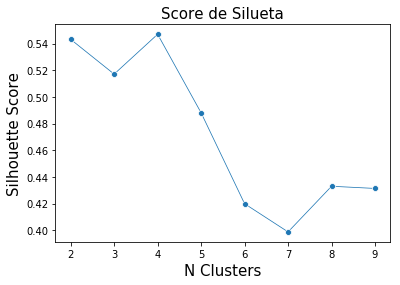

In [47]:
from sklearn.metrics import silhouette_score, silhouette_samples

sil = []
k_values = range (2,10)

for k in k_values:
    kmeans = KMeans(n_clusters = k, n_init = 10, random_state = 12)
    kmeans.fit(X_block_scaled)
    score = silhouette_score(X_block_scaled, kmeans.labels_)
    sil.append(score)
    
sns.lineplot(x = k_values, y = sil, marker = 'o', size = 30, legend = False);
plt.ylabel('Silhouette Score', fontsize = 15);plt.xlabel('N Clusters', fontsize = 15);
plt.title('Score de Silueta', fontsize = 15);
plt.savefig('block clustering - kmeans - silhouette.png')

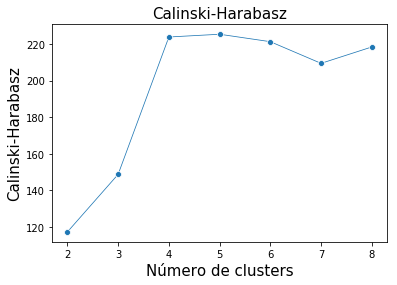

In [48]:
k_values=range(2,9);
ch_scores=[]

for k in k_values:
    
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(X_block_scaled)
    score=calinski_harabasz_score(X_block_scaled,kmeans.labels_)
    ch_scores.append(score)

sns.lineplot(x=k_values,y=ch_scores,marker='o',size=30,legend=False);
plt.ylabel('Calinski-Harabasz',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);
plt.title('Calinski-Harabasz', fontsize = 15);
plt.savefig('block clustering - kmeans - c-h.png')

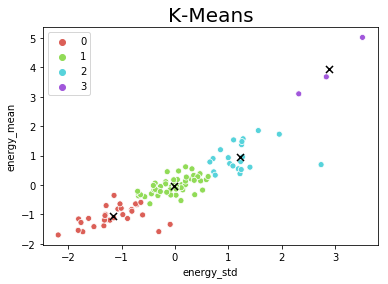

In [49]:
kmeans = KMeans(n_clusters = 4, n_init = 10, random_state = 0)
kmeans.fit(X_block_scaled)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_

sns.scatterplot(x=X_block_scaled[:,0],y=X_block_scaled[:,1],hue=labels,legend='full',palette=sns.color_palette("hls", 4));
plt.xlabel('energy_std',fontsize=10);plt.ylabel('energy_mean',fontsize=10);
plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=50,color='k');
plt.title('K-Means', fontsize = 20);
plt.savefig('block clustering - kmeans - resultados.png')

### Clustering Jerárquico

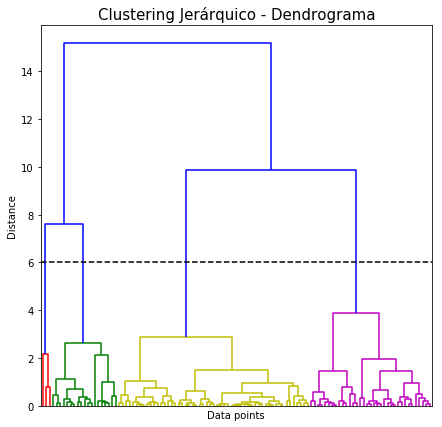

In [50]:
Z = linkage(X_block_scaled, 'ward');

plt.figure(figsize=[7,7])
plt.title('Clustering Jerárquico - Dendrograma', fontsize = 15)
plt.xlabel('Data points')
plt.ylabel('Distance')

color_palette=['r','g','y','m'];

hierarchy.set_link_color_palette(color_palette) 

dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=5.,  
    color_threshold=6,     
)
plt.hlines(6,0,2000,linestyle='--')
plt.xticks([])
plt.savefig('block clustering - jerarquico - dendograma.png')
plt.show()

In [51]:
c, dists = cophenet(Z, pdist(X_block_scaled))
print('Coeficiente cofenético: ', c)

Coeficiente cofenético:  0.6586144312563562


Cluster labels:
 [1 1 2 4 4 4 4 3 4 4 4 4 4 2 3 2 2 3 2 3 3 3 3 3 1 3 4 3 3 2 3 3 3 2 2 2 2
 3 4 3 2 3 3 3 3 3 3 3 3 3 4 4 4 4 4 3 3 2 4 3 4 4 3 4 4 3 3 3 2 3 3 3 3 4
 3 2 3 2 3 2 3 3 3 2 3 3 3 3 4 3 2 3 3 3 3 3 3 4 4 3 3 2 4 4 4 4 4 4 4 4 4
 4]


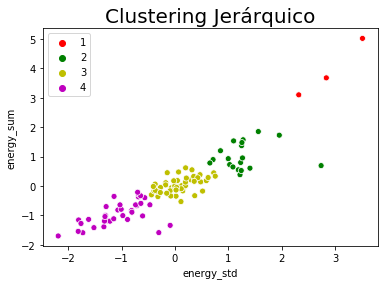

In [52]:
labels=fcluster(Z,4,criterion='maxclust');

print('Cluster labels:\n',labels)

sns.scatterplot(x = X_block_scaled[:,0] , y = X_block_scaled[:,1], hue = labels, legend = 'full', palette = color_palette);
plt.xlabel('energy_std', fontsize = 10);plt.ylabel('energy_sum',fontsize = 10);
plt.title('Clustering Jerárquico', fontsize = 20);
plt.savefig('block clustering - jerarquico - resultados.png')

In [53]:
df_block_clustering = df_block_clustering.reset_index()
df_block_clustering['cluster'] = labels

In [54]:
pd.set_option('display.max_rows', None)
df_block_clustering.sort_values(by = ['energy_mean', 'energy_std'], ascending = True)

,block,energy_std,energy_mean,cluster
12,block_109,0.104793,0.131436,4
5,block_102,0.119388,0.136763,4
104,block_92,0.164466,0.136935,4
108,block_96,0.116646,0.139007,4
11,block_108,0.125977,0.145132,4
103,block_91,0.131885,0.146560,4
105,block_93,0.171193,0.148901,4
109,block_97,0.118299,0.151974,4
106,block_94,0.135491,0.155780,4
110,block_98,0.132234,0.155931,4


In [55]:
cluster_3_mask = df_block_clustering['cluster']==4
cluster_3_list = df_block_clustering.loc[cluster_3_mask, 'block']
cluster_3_list.values

array(['block_100', 'block_101', 'block_102', 'block_103', 'block_105',
       'block_106', 'block_107', 'block_108', 'block_109', 'block_21',
       'block_32', 'block_43', 'block_44', 'block_45', 'block_46',
       'block_47', 'block_50', 'block_52', 'block_53', 'block_55',
       'block_56', 'block_64', 'block_78', 'block_86', 'block_87',
       'block_90', 'block_91', 'block_92', 'block_93', 'block_94',
       'block_95', 'block_96', 'block_97', 'block_98', 'block_99'],
      dtype=object)

In [56]:
df_block_clustering.to_csv('block_clustering.csv', index = False)